# Titanic: preprocessing and SVM

On the [Titanic datasets](https://www.kaggle.com/c/titanic/data), we want to practice a bit with data analysis, preprocessing and with the pandas library. The contents are: data import and exploration, data analysis, preprocessing and model training.

Let's import the data and start to explore it.

In [1]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('datasets/titanic/train.csv', sep=',')
df_test = pd.read_csv('datasets/titanic/test.csv', sep=',')

df_train.shape

(891, 12)

In [2]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The dataset has 891 examples and 12 features, numerical and categorical.

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Some examples miss the features Age, Cabin or Embarked. Let's see how many of them.

In [4]:
pd.isnull(df_train).sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

The Age value is missed by 177 examples, then we can imput the missing one and keep the feature. Altought the Cabin feature could be correlated with the survivors because of the position of the cabin in the ship, 687 examples miss the Cabin value which are a lot over the 891 total, then maybe it worth to drop it.

We drop also PassengerId, Name, Ticket, and Embarked because probably don't contribute to the precition of survival. From the Name we could extract the title, but this information could be already partially embodied in other features like Age, Pclass, Fare.

Let's describe the numerical and the categorical features.

In [5]:
df_train = df_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df_train.describe(include=['O'])

,Sex
count,891
unique,2
top,male
freq,577


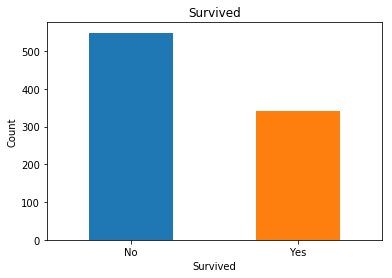

In [7]:
import matplotlib.pyplot as plt

df_train.Survived.value_counts().plot(kind='bar')
plt.xticks([0, 1], ['No', 'Yes'], rotation='horizontal')
plt.title('Survived')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.show()

In [8]:
df_train[['Sex', 'Survived']].groupby(['Sex']).mean()

,Survived
Sex,
female,0.742038
male,0.188908


We can see that the 74% of the women survived against the 18% of men. This clearly tells us that a woman is more likely to survive.

In [9]:
df_train[['Pclass', 'Survived']].groupby(['Pclass']).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


Also the ticket class is correlated with the survival. The higher the class, the higher the probability of survival.

In [10]:
df_train[['SibSp', 'Survived']].groupby(['SibSp']).mean()

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


Having siblings or spouse influence the chance. No one related to you could mean that your are travelling alone, thus, in case of men, it is less likely to jump on a lifeboat.

In [11]:
df_train[['Parch', 'Survived']].groupby(['Parch']).mean()

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


This data is similar to the SibSp. Probably, parents and children were allowed to stay together on the lifeboat. People without others are likely to be neither too young, nor in an age common to have children.

In [12]:
bins_fare = np.linspace(0, df_train.Fare.max(), 5)
df_train[['Fare', 'Survived']].groupby(pd.cut(df_train['Fare'], bins_fare)).mean()

,Fare,Survived
Fare,,
"(0.0, 128.082]",24.433432,0.373508
"(128.082, 256.165]",176.034334,0.724138
"(256.165, 384.247]",262.791667,0.666667
"(384.247, 512.329]",512.329200,1.000000


We cut Fare in 4 bins. There seems to be a relation between Fare and Survived. Fare could be a redundant variable due to the Pclass feature. Let's see their correlation.

In [13]:
df_train[['Fare', 'Pclass']].corr()

,Fare,Pclass
Fare,1.0000,-0.5495
Pclass,-0.5495,1.0000


There seems to be highly correlated, but maybe not enough. Let's keep both in the model.

In [14]:
df_train.Fare = pd.cut(df_train.Fare, bins_fare)
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,"(0.0, 128.082]"
1,1,1,female,38.0,1,0,"(0.0, 128.082]"
2,1,3,female,26.0,0,0,"(0.0, 128.082]"
3,1,1,female,35.0,1,0,"(0.0, 128.082]"
4,0,3,male,35.0,0,0,"(0.0, 128.082]"


The Age feature has some missing values, so let's impute them with the mean among the other examples with the same Survived value. After that, let's cut the age values in bins of size 10.

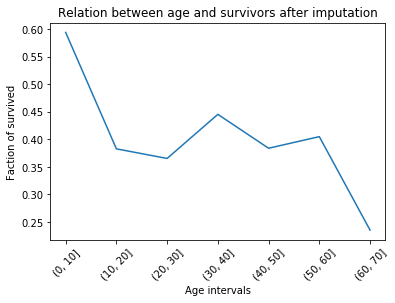

In [15]:
import math

mean_age_s0 = df_train.loc[df_train.Survived == 0, 'Age'].mean()
mean_age_s1 = df_train.loc[df_train.Survived == 1, 'Age'].mean()

df_train.loc[df_train.Survived == 0, 'Age'].fillna(mean_age_s0, inplace=True)
df_train.loc[df_train.Survived == 1, 'Age'].fillna(mean_age_s1, inplace=True)

# a bin each 10 from 0 to the max age rounded up to the nearest ten (e.g. 83 -> 90)
bins_age = np.arange(0, int(math.ceil(df_train.Age.max() / 10.0)) * 10, 10)
df_age_cut = df_train[['Age', 'Survived']].groupby(pd.cut(df_train['Age'], bins_age))
mean = df_age_cut.mean()
plt.xticks(np.arange(len(mean)), mean.index.values, rotation=45)
plt.plot(mean.Survived.values)
plt.title('Relation between age and survivors after imputation')
plt.xlabel('Age intervals')
plt.ylabel('Faction of survived')
plt.show()

The plot suggests that the children are more likely to survive, and the people in (30, 40] as well, maybe because there are tied by a parent/children relation.

Now, let's encode the categorical features with a One Hot encoding (like OneHotEncoder does) and see how an SVM performes without tuning parameter. We set the test set size by 30% of the dataset.

In [16]:
df_train.Age = pd.cut(df_train['Age'], bins_age)

df_train_onehot = pd.get_dummies(df_train)
df_train_onehot.head()

,Survived,Pclass,SibSp,Parch,Sex_female,Sex_male,"Age_(0, 10]","Age_(10, 20]","Age_(20, 30]","Age_(30, 40]","Age_(40, 50]","Age_(50, 60]","Age_(60, 70]","Fare_(0.0, 128.082]","Fare_(128.082, 256.165]","Fare_(256.165, 384.247]","Fare_(384.247, 512.329]"
0,0,3,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0
1,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0
2,1,3,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
3,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0
4,0,3,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

df_train_onehot_X = df_train_onehot.drop('Survived', axis=1)

x_train, x_val, y_train, y_val = train_test_split(df_train_onehot_X, df_train_onehot.Survived, test_size=0.30, random_state=0)

clf = SVC(gamma='auto')
clf.fit(x_train, y_train)
clf.score(x_val, y_val)

0.80970149253731338

The SVM performs with an accuracy of 0.8097. Now, let's see if the accuracy changes encoding the categorical features assigning one numerical class for each different value (like LabelEncoder does).

In [18]:
df_train.Age = df_train.Age.astype('category').cat.codes
df_train.Sex = df_train.Sex.astype('category').cat.codes
df_train.Fare = df_train.Fare.astype('category').cat.codes

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,2,1,0,0
1,1,1,0,3,1,0,0
2,1,3,0,2,0,0,0
3,1,1,0,3,1,0,0
4,0,3,1,3,0,0,0


In [19]:
df_train_X = df_train.drop('Survived', axis=1)

x_train, x_val, y_train, y_val = train_test_split(df_train_X, df_train.Survived, test_size=0.30, random_state=0)

clf.fit(x_train, y_train)
clf.score(x_val, y_val)

0.81343283582089554

It seems that label encoding method works better, but maybe the difference is still to little to prefer one over the other.

Let's evaluate it against the validation set.

In [20]:
df_test_ids = df_test['PassengerId']
df_test = df_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
df_test.Fare = pd.cut(df_test.Fare, bins_fare)
df_test.Age = pd.cut(df_test.Age, bins_age)

df_test.Age = df_test.Age.astype('category').cat.codes
df_test.Sex = df_test.Sex.astype('category').cat.codes
df_test.Fare = df_test.Fare.astype('category').cat.codes

predictions = clf.predict(df_test)

output = pd.DataFrame({ 'PassengerId' : df_test_ids, 'Survived': predictions })
output.to_csv('output/titanic_submission.csv', index=False)